## CNN On FashionMNIST

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torch.optim import Adam
from torchvision import datasets
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt,matplotlib.ticker as mticker
import seaborn as sns
%matplotlib inline
device='cuda' if torch.cuda.is_available() else 'cpu'
fmnist=datasets.FashionMNIST(r'../data',download=True,train=True)
val_fmnist=datasets.FashionMNIST(r'../data',download=True,train=False)
tr_images,tr_targets=fmnist.data,fmnist.targets
val_images,val_targets=val_fmnist.data,val_fmnist.targets

In [2]:
class FMNISTDataset(Dataset):
    def __init__(self,x,y):
        self.x,self.y=x.float().view(-1,1,28,28)/255,y
    def __getitem__(self, item):
        return self.x[item].to(device),self.y[item].to(device)
    def __len__(self):
        return len(self.x)
    
def get_model():
    model=nn.Sequential(
        nn.Conv2d(1,64,kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Conv2d(64,128,kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(3200,256),
        nn.ReLU(),
        nn.Linear(256,10)
    ).to(device)
    loss_fn=nn.CrossEntropyLoss()
    optimizer=Adam(model.parameters(),lr=1e-3)
    return model,loss_fn,optimizer

def train_batch(x,y,model,opt,loss_fn):
    model.train()
    batch_loss=loss_fn(model(x),y)
    batch_loss.backward()
    opt.step()
    opt.zero_grad()
    return batch_loss.item()

def accuracy(x,y,model):
    model.eval()
    with torch.no_grad():
        prediction=model(x)
    max_values,argmaxes=prediction.max(-1)
    is_correct=argmaxes==y
    return is_correct.cpu().numpy().tolist()

def get_data():
    train=FMNISTDataset(tr_images,tr_targets)
    trn_dl=DataLoader(train,batch_size=32,shuffle=True)
    val=FMNISTDataset(val_images,val_targets)
    val_dl=DataLoader(val,batch_size=len(val_images),shuffle=False)
    return trn_dl,val_dl

@torch.no_grad()
def val_loss(x,y,model,loss_fn):
    model.eval()
    val_loss=loss_fn(model(x),y)
    return val_loss.item()

In [3]:
trn_dl,val_dl=get_data()
model,loss_fn,optimizer=get_model()
summary(model,torch.zeros(1,1,28,28).shape[1:])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 26, 26]             640
         MaxPool2d-2           [-1, 64, 13, 13]               0
              ReLU-3           [-1, 64, 13, 13]               0
            Conv2d-4          [-1, 128, 11, 11]          73,856
         MaxPool2d-5            [-1, 128, 5, 5]               0
              ReLU-6            [-1, 128, 5, 5]               0
           Flatten-7                 [-1, 3200]               0
            Linear-8                  [-1, 256]         819,456
              ReLU-9                  [-1, 256]               0
           Linear-10                   [-1, 10]           2,570
Total params: 896,522
Trainable params: 896,522
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.69
Params size (MB): 3.42
Estimated T

In [4]:

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)        
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model,loss_fn)
    val_epoch_accuracy = np.mean(val_is_correct)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4


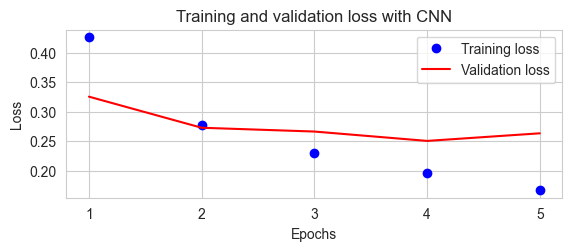

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_29140\1078572435.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{x*100:.0f}%' for x in plt.gca().get_yticks()])


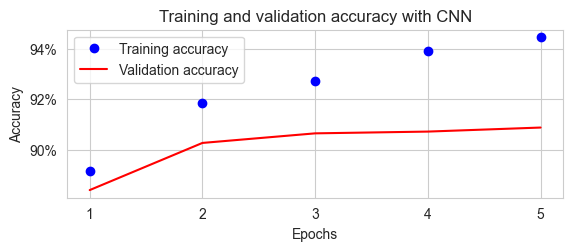

In [5]:
epochs = np.arange(5)+1
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with CNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.8,1)
plt.gca().set_yticklabels([f'{x*100:.0f}%' for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

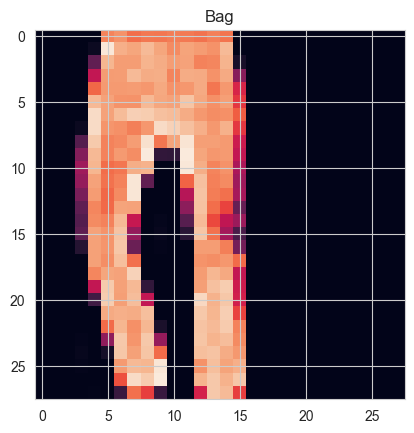

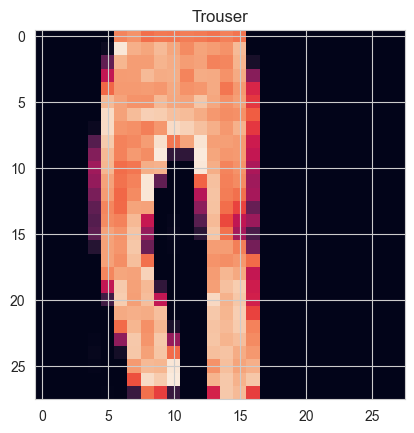

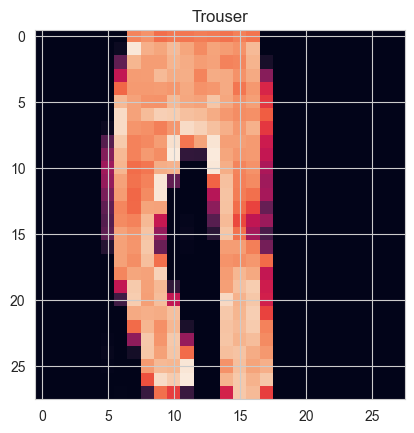

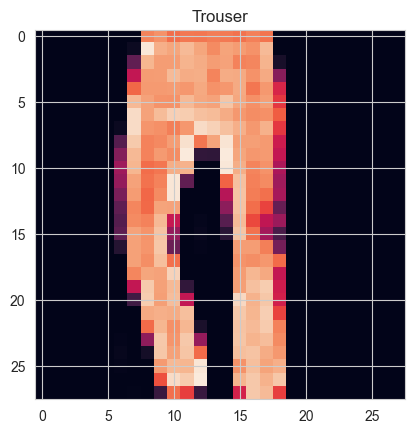

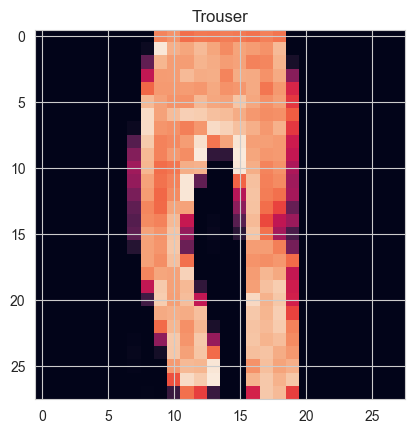

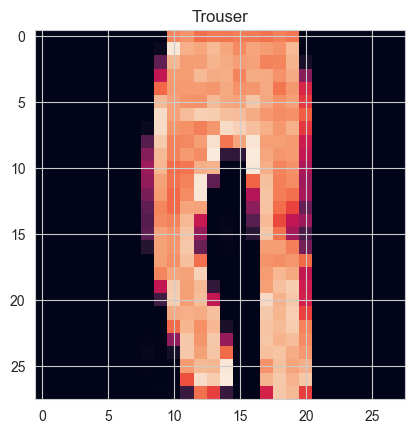

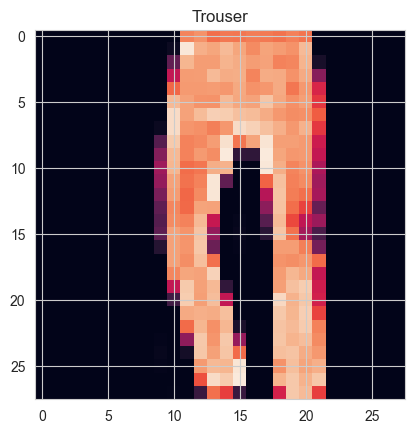

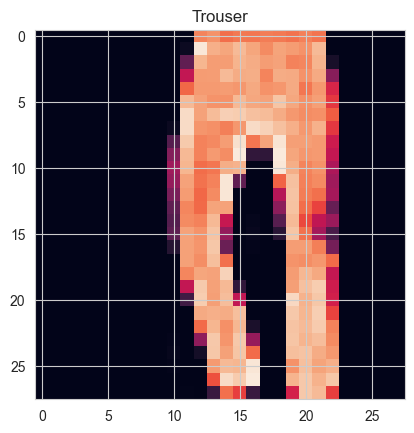

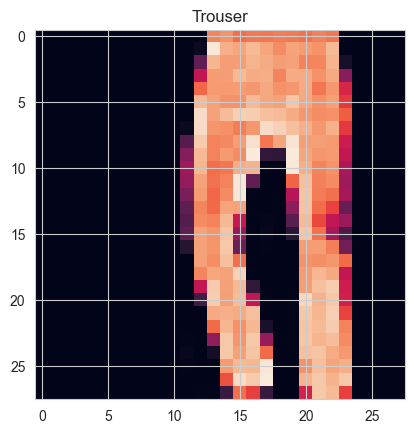

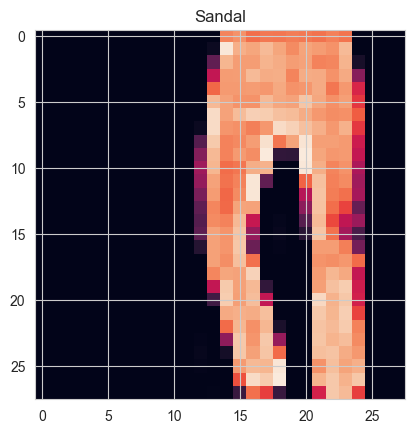

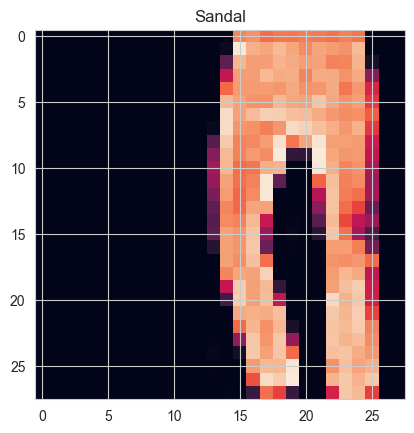

In [6]:
preds = []
ix = 24300
for px in range(-5,6):
    img = tr_images[ix]/255.
    img = img.view(28, 28)
    img2 = np.roll(img, px, axis=1)
    img3 = torch.Tensor(img2).view(-1,1,28,28).to(device)
    np_output = model(img3).cpu().detach().numpy()
    pred = np.exp(np_output)/np.sum(np.exp(np_output))
    preds.append(pred)
    plt.imshow(img2)
    plt.title(fmnist.classes[pred[0].argmax()])
    plt.show()

In [7]:
np.array(preds).shape

(11, 1, 10)

<Axes: title={'center': 'Probability of each class for various translations'}>

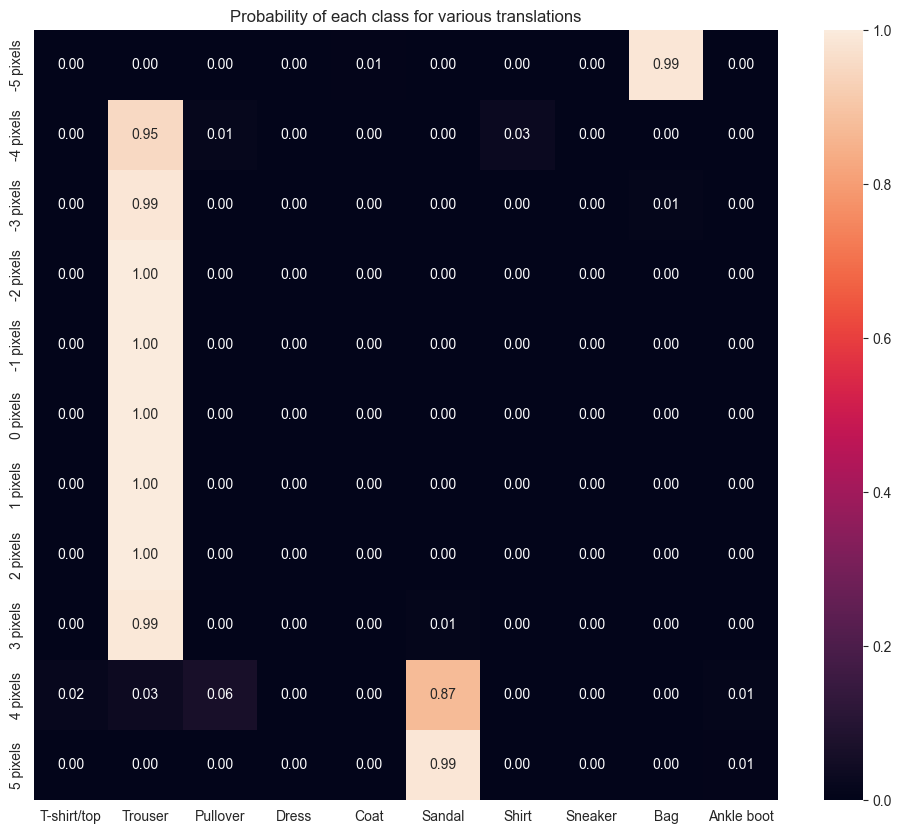

In [8]:
fig, ax = plt.subplots(1,1, figsize=(12,10))
plt.title('Probability of each class for various translations')
sns.heatmap(np.array(preds).reshape(11,10), annot=True, ax=ax, fmt='.2f', xticklabels=fmnist.classes, yticklabels=[str(i)+str(' pixels') for i in range(-5,6)])